In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *
from graph_format import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


In [2]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [3]:
rows_to_drop = np.arange(40+70+55, 40+70+55+15)
cols_to_drop = np.arange(40+70+55, 40+70+55+15)

mean_drop = np.delete(mean, rows_to_drop, axis=0)

weights_drop = np.delete(weights, rows_to_drop, axis=0)
weights_drop = np.delete(weights_drop, cols_to_drop, axis=1)


In [4]:
var1 = np.mean(mean[:40])
var2 = np.mean(mean[40:110])
var3 = np.mean(mean[110:165])
var4 = np.mean(mean[180:])

n = 205
test_weight = np.zeros((n, n))

# fill only the four blocks with 1/var^2
blocks = [
    (0,    40,  var1),
    (40,  110,  var2),
    (110, 165,  var3),
    (180, 205,  var4)
]

for start, end, v in blocks:
    idx = np.arange(start, end)
    test_weight[idx, idx] = 1.0 / (v**2)


In [5]:
def randomize_theta_init(theta_init, bounds, pct=0.05):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1")

theta_init = np.array([0.964943, 1.151436, 1.892169, 6.619750, 7.322572, 0.050859])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               (0.0, 1.0)
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

In [6]:
# # Do SMM
# objective = lambda theta: obj_func(theta, theta_names, mean_drop, weights_drop, model, orig_bounds, do_print=True)

# res = minimize(
#     objective, 
#     theta_init_scaled,
#     method='nelder-mead',
#     bounds=[(0,1)] * len(theta_init_scaled),
#     tol=1e-6,
#     options={"maxiter":2000}
# )


In [7]:
def solve_and_sim():
    model.solve()
    model.simulate()

    setattr(model.par, )

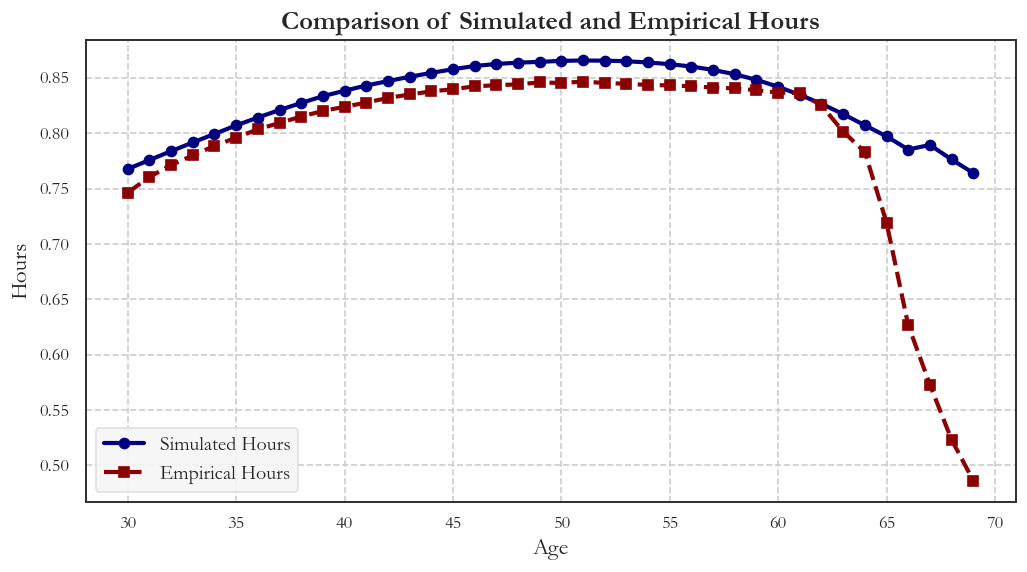

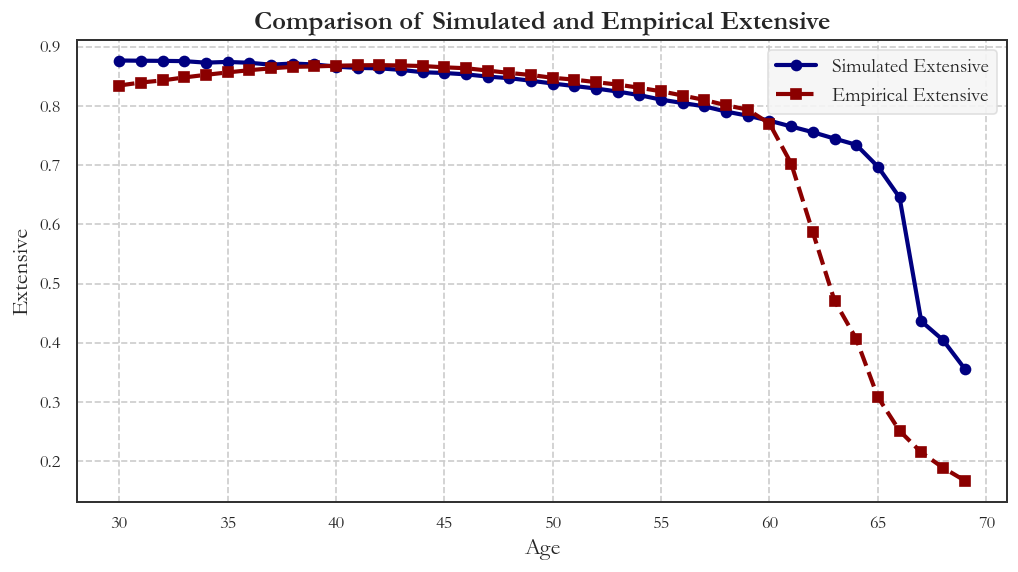

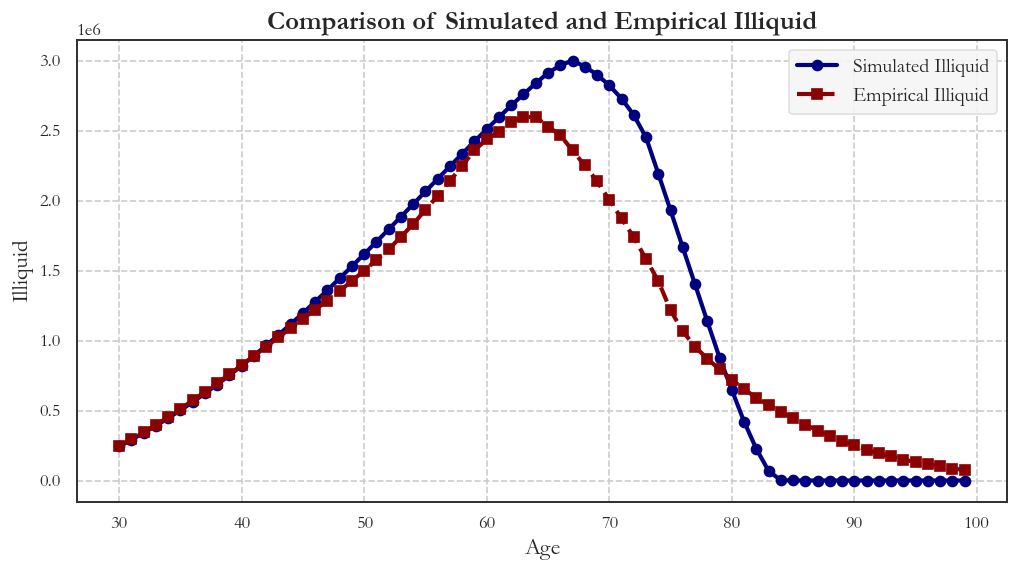

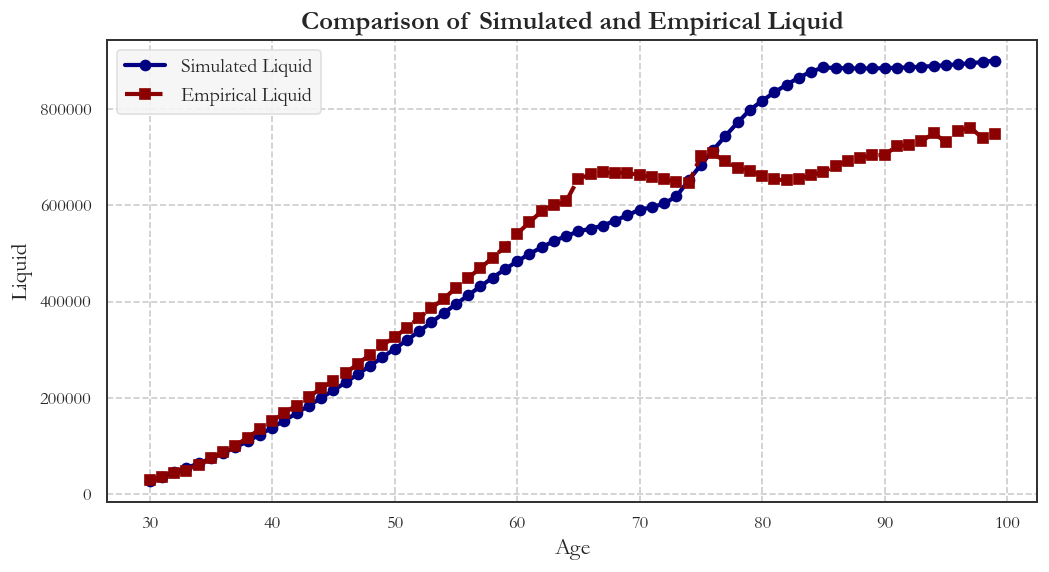

In [8]:
# Load the model with calibrated values
# theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1")
# theta_names = ("beta", "zeta")
# # theta_final = unscale_params(res.x, orig_bounds)
# # theta_final = theta_init

# theta_final = np.array([0.967331, 7.475348])

# for i, name in enumerate(theta_names):
#     setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
from consav.linear_interp import interp_1d, interp_2d, interp_3d, interp_4d

In [10]:
for test_range in range(50):

    t = test_range
    i = 8

    count = 0

    test_list_emp = []
    test_list_unemp = []

    for i in range(50000):
        model = model
        # model = og_model

        sol_v_unemp = interp_3d(par.a_grid, par.s_grid, par.k_grid[t], model.sol.V[t,:,:,:,t, int(par.unemp)], model.sim.a[i,t], model.sim.s[i,t], model.sim.k[i,t])
        sol_v_emp = interp_3d(par.a_grid, par.s_grid, par.k_grid[t], model.sol.V[t,:,:,:,t, int(par.emp)], model.sim.a[i,t], model.sim.s[i,t], model.sim.k[i,t])

        test_list_emp.append(sol_v_unemp)
        test_list_unemp.append(sol_v_emp)

        # print("Emp", abs(sol_v_emp), "unemp", abs(sol_v_unemp), (sol_v_emp > sol_v_unemp), "diff", abs(sol_v_emp) - abs(sol_v_unemp))

        if sol_v_emp > sol_v_unemp:
            # print(i, "emp higher")

            count += 1

    print(t, count)

        # model.sol.V[t,:,:,:,t, int(par.emp)]


0 46051
1 46039
2 46039
3 46038
4 46038
5 46037
6 46037
7 46037
8 46032
9 46030
10 46025
11 46020
12 46012
13 45999
14 45985
15 45965
16 45943
17 45916
18 45892
19 45844
20 45796
21 45741
22 45666
23 45583
24 45484
25 45381
26 45263
27 45091
28 44898
29 44724
30 44485
31 44190
32 43864
33 43490
34 43091
35 43645
36 43129
37 32438
38 40534
39 36549
40 47445
41 44628
42 38364
43 9363
44 31384
45 33037
46 36551
47 10615
48 44898
49 48957


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}


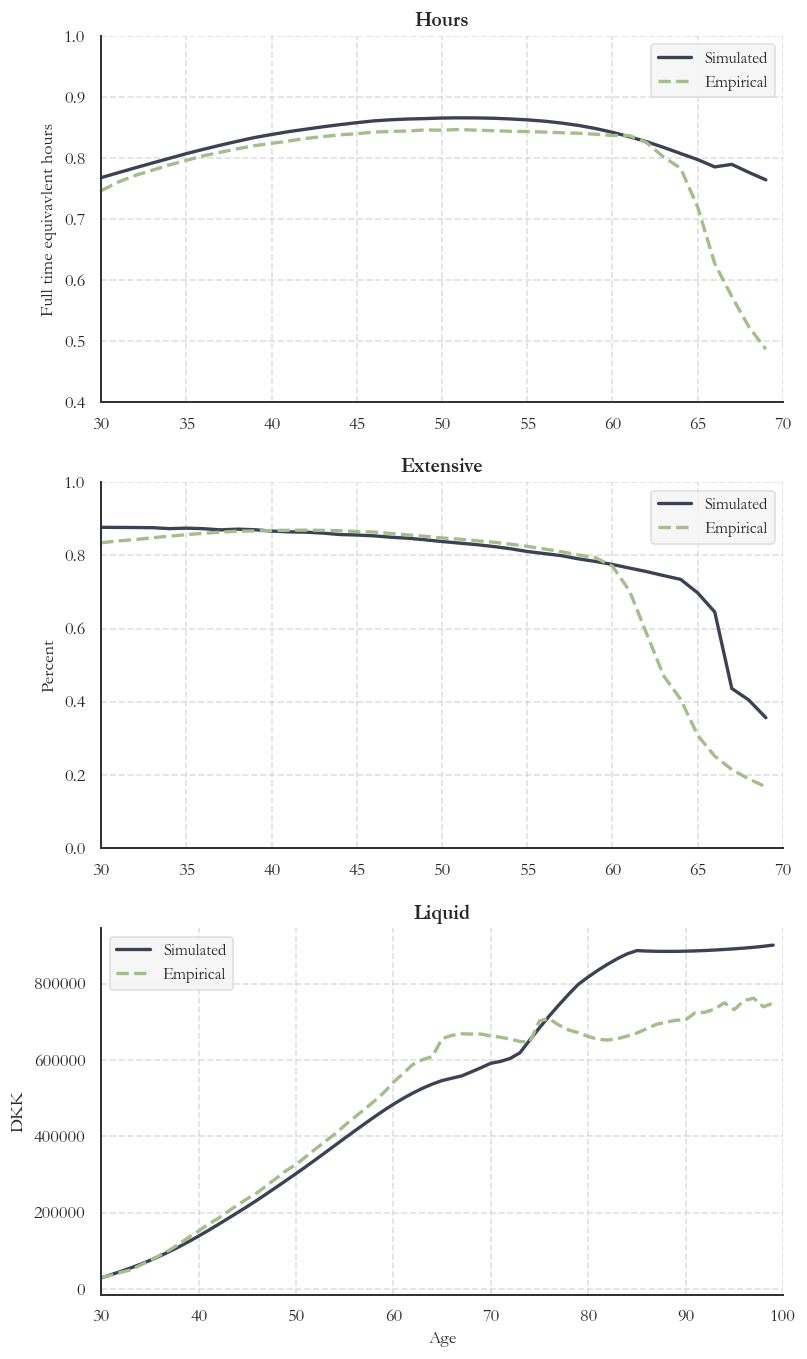

In [12]:
plot_model_vs_data_grid(a_dict, title="", save_title="in_sample_fit.png")


In [13]:
means_data = pd.read_csv("Data/mean_matrix.csv")

b_dict = {
    'illiquid': [np.clip(np.clip(np.mean(model.sim.s, axis=0), 0, None) / 1_000_000, 0, None),
                 moments['savings'] / 1_000_000]  ,
    'wages':    [np.nanmean(np.where(model.sim.ex==1, model.sim.w, np.nan)[:, :31] , axis=0),
                 means_data[means_data["alder"] <= 60]["hourly_salary_plsats_Mean"].to_numpy() * 1924]
        }

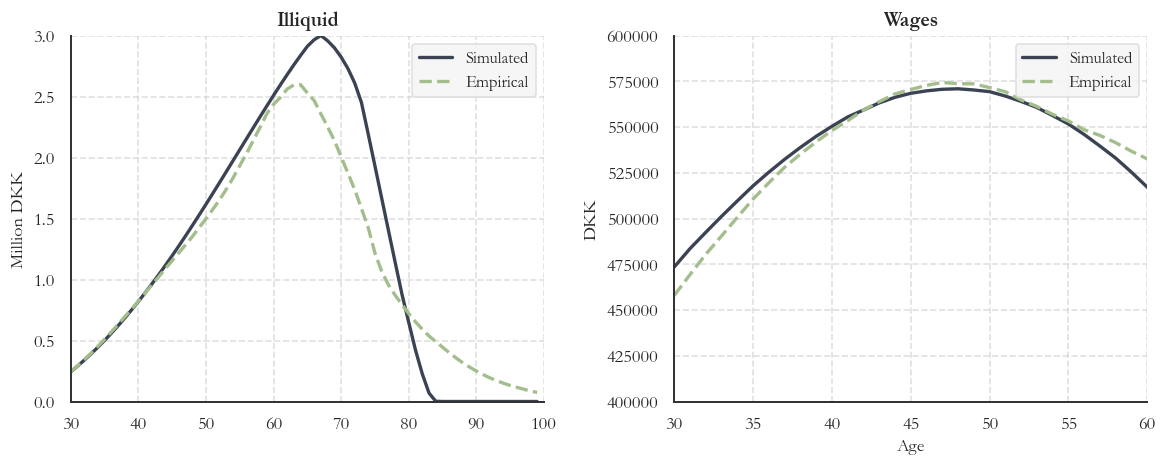

In [14]:
plot_model_vs_data_grid_oos(b_dict, title="", save_title="out_of_sample_fit.png")
